In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training

print(torch.__version__, np.__version__)

In [ ]:
# Experiment configuration
experiment_name = "dpf_feb19_new2"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [ ]:
# Create models & training buddy

dynamics_model = panda_models.PandaDynamicsModel()
measurement_model = panda_models.PandaMeasurementModel()

pf_model = panda_models.PandaParticleFilterNetwork(
    dynamics_model,
    measurement_model
)

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "dynamics_recurrent", "measurement"]
)

# Dynamics Model Pre-Training

In [ ]:
dynamics_trainset = panda_datasets.PandaDynamicsDataset(
    "data/gentle_push_1000.hdf5",
    **dataset_args
)
dynamics_recurrent_trainset = panda_datasets.PandaSubsequenceDataset(
    "data/gentle_push_1000.hdf5",
    subsequence_length=32,
    **dataset_args
)

In [ ]:
dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=32, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.02, .02)

for i in range(5):
    print("Training epoch", i)
    panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=1)
    print()

buddy.save_checkpoint("phase_0_dynamics_pretrain")

In [ ]:
dataloader = torch.utils.data.DataLoader(dynamics_recurrent_trainset, batch_size=32, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.02, .02)

for i in range(3):
    print("Training epoch", i)
    panda_training.train_dynamics_recurrent(buddy, pf_model, dataloader, log_interval=1, loss_type='l2')
    print()

buddy.save_checkpoint("phase_1_dynamics_pretrain_recurrent")

# Measurement Model Pre-Training

In [ ]:

measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/gentle_push_1000.hdf5",
    samples_per_pair=10,
    **dataset_args
)

In [ ]:
measurement_trainset_loader = torch.utils.data.DataLoader(
    measurement_trainset,
    batch_size=32,
    shuffle=True,
    num_workers=16)

for i in range(5):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20)
    print()



In [10]:
buddy.save_checkpoint("phase_2_measurement_pretrain")


[buddy-dpf_feb19_new2] Saved checkpoint to path: checkpoints/dpf_feb19_new2-phase_2_measurement_pretrain.ckpt


# End-to-end Training

In [11]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/gentle_push_1000.hdf5",
    subsequence_length=16,
    particle_count=30,
    particle_stddev=(.1, .1),
    **dataset_args
)

Parsed data: 13331 active, 1669 inactive
Keeping (inactive): 1669


In [12]:
print(len(e2e_trainset.subsequences))

15000


In [13]:
##### Train end-to-end
pf_model.dynamics_model.state_noise_stddev = (0.01, 0.01)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
for i in range(5):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse")

Training epoch 0



Epoch loss: 0.0010535392
Training epoch 1



Epoch loss: 0.0007841551
Training epoch 2



Epoch loss: 0.0009964929
Training epoch 3



Epoch loss: 0.0016213141
Training epoch 4



Epoch loss: 0.000905356


In [14]:
buddy.save_checkpoint("phase_3_end_to_end_trained")
buddy.save_checkpoint()

[buddy-dpf_feb19_new2] Saved checkpoint to path: checkpoints/dpf_feb19_new2-phase_3_end_to_end_trained.ckpt
[buddy-dpf_feb19_new2] Saved checkpoint to path: checkpoints/dpf_feb19_new2-0000000000183657.ckpt


# Model eval

In [15]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

### Final Model

[buddy-dpf_feb19_new2] Loaded checkpoint from path: checkpoints/dpf_feb19_new2-phase_0_dynamics_pretrain.ckpt
phase_0_dynamics_pretrain


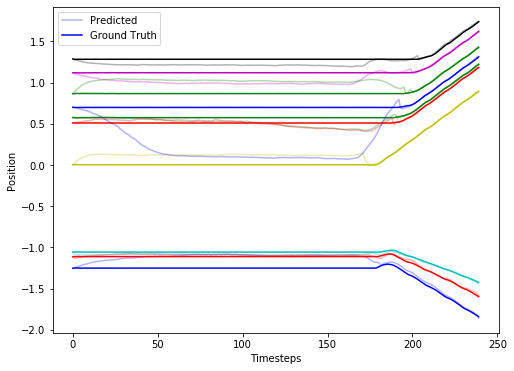

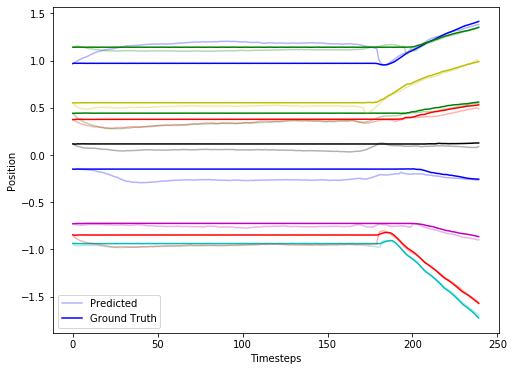

X RMSE:  0.1656856061660105
Y RMSE:  0.08156996502198441
(0.01, 0.01)
[buddy-dpf_feb19_new2] Loaded checkpoint from path: checkpoints/dpf_feb19_new2-phase_1_dynamics_pretrain_recurrent.ckpt
phase_1_dynamics_pretrain_recurrent


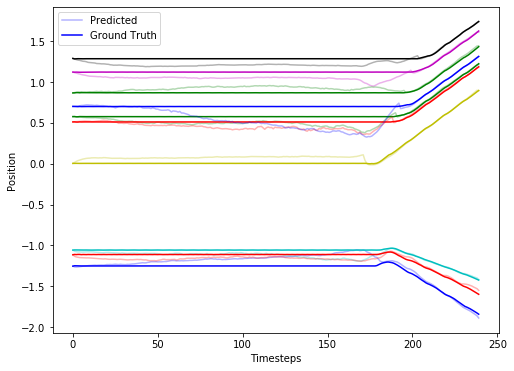

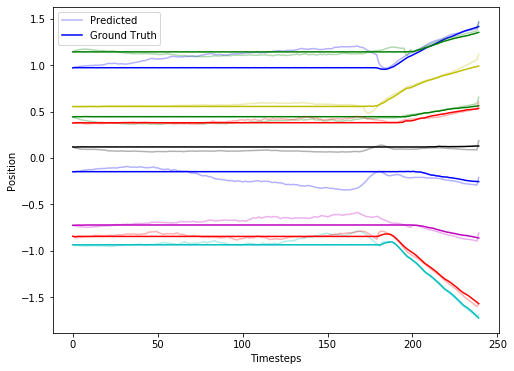

X RMSE:  0.08421010451142928
Y RMSE:  0.061601787908025396
(0.01, 0.01)
[buddy-dpf_feb19_new2] Loaded checkpoint from path: checkpoints/dpf_feb19_new2-phase_2_measurement_pretrain.ckpt
phase_2_measurement_pretrain


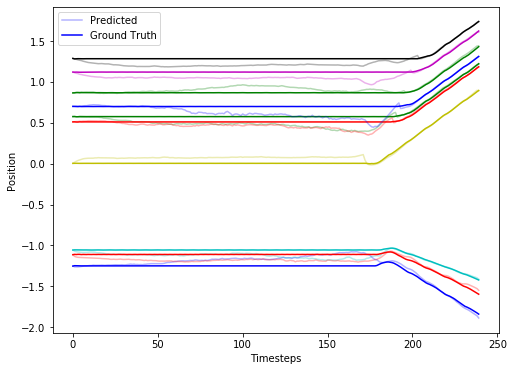

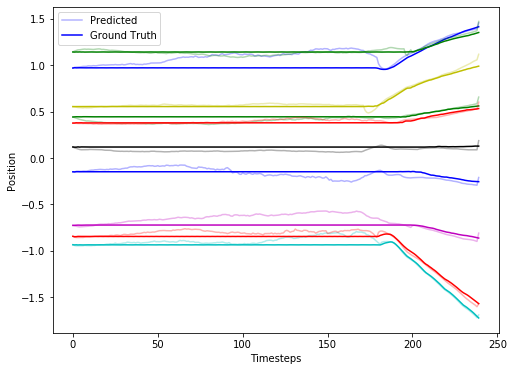

X RMSE:  0.0696241466508573
Y RMSE:  0.0576497704345172
(0.01, 0.01)
[buddy-dpf_feb19_new2] Loaded checkpoint from path: checkpoints/dpf_feb19_new2-phase_3_end_to_end_trained.ckpt
phase_3_end_to_end_trained


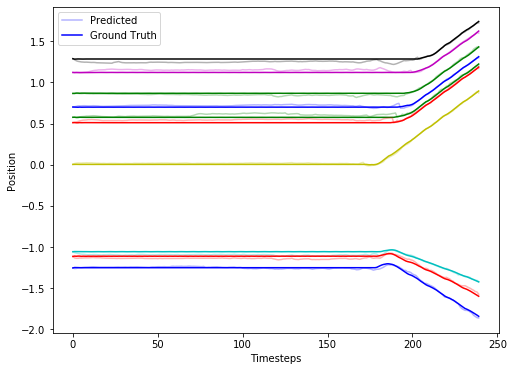

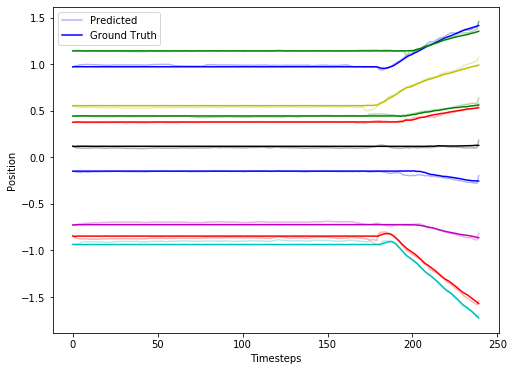

X RMSE:  0.026032568329985364
Y RMSE:  0.01903061130945806
(0.01, 0.01)


In [17]:
phases = [
    'phase_0_dynamics_pretrain',
    'phase_1_dynamics_pretrain_recurrent',
    'phase_2_measurement_pretrain',
    'phase_3_end_to_end_trained'
]
for phase in phases:
    buddy.load_checkpoint(phase)
    print(phase)
    pf_model.dynamics_model.state_noise_stddev = (0.01, 0.01)
    pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
    panda_training.eval_rollout(pred, actual, plot=True)
    print(pf_model.dynamics_model.state_noise_stddev)

### Model without end-to-end training

In [ ]:
# pf_model.dynamics_model.state_noise = (0.005, 0.005)


# # Back up model
# buddy.save_checkpoint()

# # Load the pre-end-to-end-training version of the model & evaluate
# buddy.load_checkpoint(label="before_e2e_training")

# pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
# panda_training.eval_rollout(pred, actual, plot=True)

# # Restore model
# buddy.load_checkpoint()

In [ ]:
buddy.save_checkpoint()